# Understanding Structure Functions
*Part 2 of AGN Variability.*

## Introduction

Structure functions (SFs) are used to quantify variability. 

They are very helpful tools when performing time series analysis, especially in inoptimal cadence applications, like ground-based astronomical surveys.

In this notebook, we will explore what SFs are and how they can characterize AGN variability

## Simulating an AGN Lightcurve
We begin by simulating an AGN lightcurve using a damped random walk (DRW) process.

DRWs are pretty standard for modelling random things that need some concept of the past (e.g. AGNs, turbulence, stock prices with mean-reverting behavior, and more).

*Note that some recent-ish research has suggested viability of alternative methods, such as CARMA models, but we're ultimately using real data in our AGN analysis, so we won't really explore this.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def simulate_agn_drw(t, tau, sigma, mean_mag=0, seed=None):
    """Simulates an AGN lightcurve using a Damped Random Walk (DRW) model.

    Parameters
    ----------
    t : array-like
        Array of time values (in days). Can be irregularly spaced.
    tau : float
        Characteristic timescale of the DRW process (in days).
    sigma : float
        Long-term standard deviation of the lightcurve variations.
    mean_mag : float, optional
        Mean magnitude or flux level of the AGN, default is 0.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        Simulated lightcurve values at the input time points.
    """
    if seed is not None:
        np.random.seed(seed)

    t = np.sort(np.asarray(t))  # Ensure time array is sorted
    dt = np.diff(t)  # Time intervals
    x = np.zeros_like(t, dtype=float)  # Initialize lightcurve

    # Compute the DRW parameters
    sigma_hat = sigma * np.sqrt(2 / tau)  # Effective noise level
    exp_factor = np.exp(-dt / tau)  # Exponential damping factor

    # Generate the lightcurve iteratively
    for i in range(1, len(t)):
        x[i] = x[i-1] * exp_factor[i-1] + sigma_hat * np.sqrt(1 - exp_factor[i-1]**2) * np.random.normal()

    return x + mean_mag  # Add mean level

In [15]:
# Simulate AGN lightcurves
time = np.linspace(0, 1000, 500)  # Simulated time points in days
lightcurve_low_tau = simulate_agn_drw(time, tau=300, sigma=0.2, mean_mag=20, seed=42)
lightcurve_high_tau = simulate_agn_drw(time, tau=1000, sigma=0.2, mean_mag=20, seed=42)
lightcurve_new_seed = simulate_agn_drw(time, tau=1000, sigma=0.2, mean_mag=20, seed=43)

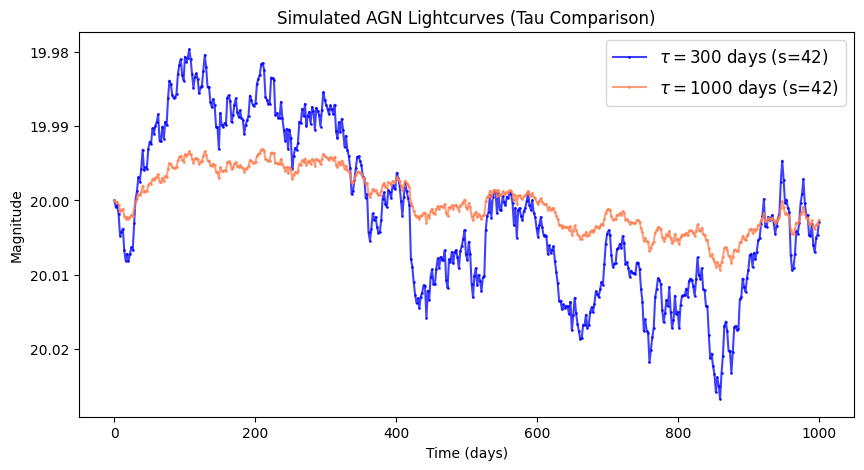

In [13]:
# Plot the simulated AGN lightcurves, comparing low and high tau values
plt.figure(figsize=(10, 5))
plt.plot(time, lightcurve_low_tau, marker='o', markersize=1, linestyle='-', color='blue', alpha=0.75, label=r"$\tau = 300$ days (s=42)")
plt.plot(time, lightcurve_high_tau, marker='o', markersize=1, linestyle='-', color='coral', alpha=0.75, label=r"$\tau = 1000$ days (s=42)")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.title("Simulated AGN Lightcurves (Tau Comparison)")
plt.gca().invert_yaxis()  # Invert y-axis since magnitudes decrease for brighter objects
plt.legend(loc="best", fontsize=12, frameon=True)
plt.show()

TODO mention tau

## Power Spectral Densities

In general, we can use a power spectral density (PSD) plot to better see the shifts in tau.

In [6]:
from scipy.signal import welch

In [7]:
def compute_psd(time, lightcurve, fs=1.0):
    """Computes the Power Spectral Density (PSD) of AGN lightcurves.

    Parameters
    ----------
    time : array-like
        Array of time values (in days). Assumed to be evenly spaced.
    lightcurve : array-like
        Lightcurve array; corresponds to a certain AGN simulation.
    fs : float, optional
        Sampling frequency (1/dt). If the time array is evenly spaced, this is `1 / (time[1] - time[0])`.

    Returns
    -------
    tuple of (np.ndarray, np.ndarray)
        Frequencies and PSD values.
    """
    dt = np.median(np.diff(time))  # Approximate sampling interval
    fs = 1.0 / dt  # Sampling frequency in 1/days


    freqs, psd = welch(lightcurve, fs=fs, nperseg=len(lightcurve)//4)
    return freqs, psd

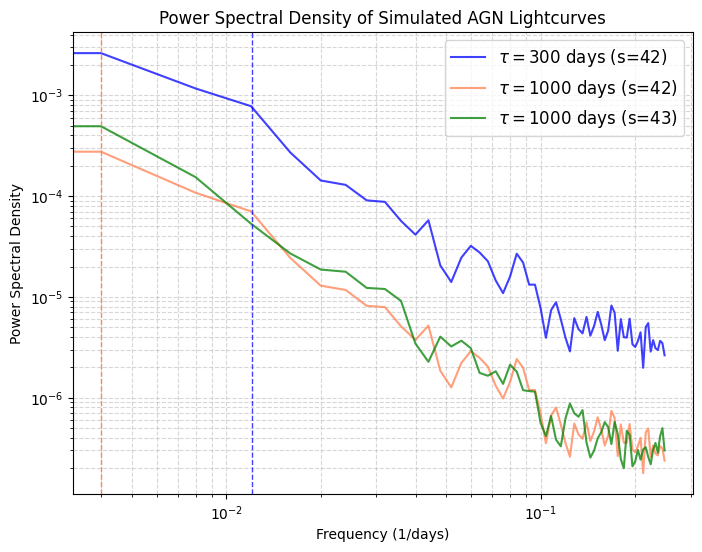

In [16]:
plt.figure(figsize=(8, 6))

plt.title("Power Spectral Density of Simulated AGN Lightcurves")
plt.xlabel("Frequency (1/days)")
plt.ylabel("Power Spectral Density")
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Compute PSDs
lightcurve_A, lightcurve_B = lightcurve_low_tau, lightcurve_high_tau
freqs_A, psd_A = compute_psd(time, lightcurve_A)
freqs_B, psd_B = compute_psd(time, lightcurve_B)
freqs_C, psd_C = compute_psd(time, lightcurve_new_seed)

# Plot PSDs
plt.loglog(freqs_A, psd_A, linestyle='-', color="blue", alpha=0.75, label=r"$\tau = 300$ days (s=42)")
plt.loglog(freqs_B, psd_B, linestyle='-', color="coral", alpha=0.75, label=r"$\tau = 1000$ days (s=42)")
plt.loglog(freqs_C, psd_C, linestyle='-', color="green", alpha=0.75, label=r"$\tau = 1000$ days (s=43)")

# Add vertical lines to mark break frequencies
plt.axvline(10**-1.92, color="blue", linestyle="dashed", linewidth=1, alpha=0.75)
plt.axvline(10**-2.4, color="coral", linestyle="dashed", linewidth=1, alpha=0.9)

plt.legend(loc="best", fontsize=12, frameon=True)
plt.show()


In theory, we might see **break frequency** shifts to the right as tau increases. I think this particular simulated data doesn't really show it, but, that's the theory. (TODO revisit the CARMA talk for this)

Otherwise, this plot is a little uninteresting (at least, for understanding the power behind PSDs). The only real difference between these two light curves was:
- their **tau**, which is why one's higher than the other (and the break frequency is shifted)
- their **random seed**, which is why the little bumps are a just a little different from each other

PSDs are really helpful for **understanding the underlying frequencies of a time domain function at a glance**.

To demonstrate this, let's add a sine wave to one of our light curves to introduce an additional level of (totally artificial) medium-timescale variablity.

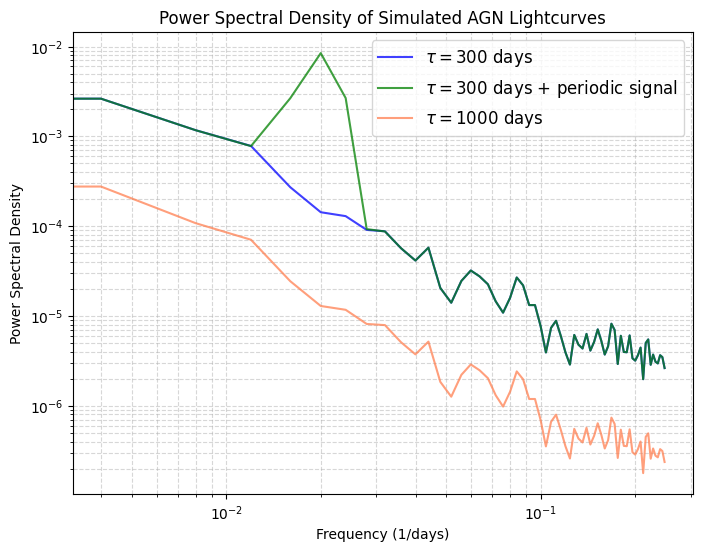

In [9]:
# Add a periodic component to a new lightcurve
f_signal = 2e-2  # Frequency of sine wave in days^-1
amplitude = 0.01  # Strength of the periodic variation
sine_wave = amplitude * np.sin(2 * np.pi * f_signal * time)

# Combine with a DRW lightcurve
lightcurve_with_bump = sine_wave + simulate_agn_drw(time, tau=300, sigma=0.2, mean_mag=20, seed=42)

# Compute PSDs
freqs_C, psd_C = compute_psd(time, lightcurve_with_bump)  # New PSD with periodic component

# Plot PSDs
plt.figure(figsize=(8, 6))
plt.title("Power Spectral Density of Simulated AGN Lightcurves")

plt.loglog(freqs_A, psd_A, linestyle='-', color="blue", alpha=0.75, label=r"$\tau = 300$ days")
plt.loglog(freqs_C, psd_C, linestyle='-', color="green", alpha=0.75, label=r"$\tau = 300$ days + periodic signal")
plt.loglog(freqs_B, psd_B, linestyle='-', color="coral", alpha=0.75, label=r"$\tau = 1000$ days")

plt.xlabel("Frequency (1/days)")
plt.ylabel("Power Spectral Density")
plt.legend(loc="best", fontsize=12, frameon=True)
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()


## Structure Functions

*Wait, Olivia--if PSDs are so cool, why do we even need structure functions (SFs)?*

Unfortunately, PSDs are not terribly robust against **sparse or intermittent data**, which is exactly the kind of data we get when we use ground-based astronomical surveys with inoptimal cadences.

(TODO--citations. Believe this was explained in the CARMA talk, but probably is touched on in Graham's 2014 paper on SWV vs SFs, too)*

In [10]:
def compute_structure_function(time, lightcurve, num_bins=50):
    """
    Computes the Structure Function (SF) from a lightcurve.

    Parameters
    ----------
    time : array-like
        Time values (in days).
    lightcurve : array-like
        Lightcurve values.
    num_bins : int, optional
        Number of bins for computing SF from a lightcurve.

    Returns
    -------
    tuple of (np.ndarray, np.ndarray)
        Time lags and corresponding SF values.
    """
    # Compute time differences and magnitude differences
    time_diffs = np.abs(time[:, None] - time[None, :]).flatten()  # 1D array
    mag_diffs = ((lightcurve[:, None] - lightcurve[None, :]) ** 2).flatten()  # Flattened to match

    # Bin the time lags logarithmically
    bins = np.logspace(np.log10(np.min(time_diffs[time_diffs > 0])),
                       np.log10(np.max(time_diffs)), num_bins)
    sf_values = np.zeros(len(bins) - 1)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Geometric mean of bin edges

    for i in range(len(bins) - 1):
        mask = (time_diffs >= bins[i]) & (time_diffs < bins[i + 1])
        if np.any(mask):  # Avoid empty bins
            sf_values[i] = np.sqrt(np.median(mag_diffs[mask]))  
        else:
            sf_values[i] = np.nan  # Fill with NaN if no data

    return bin_centers, sf_values


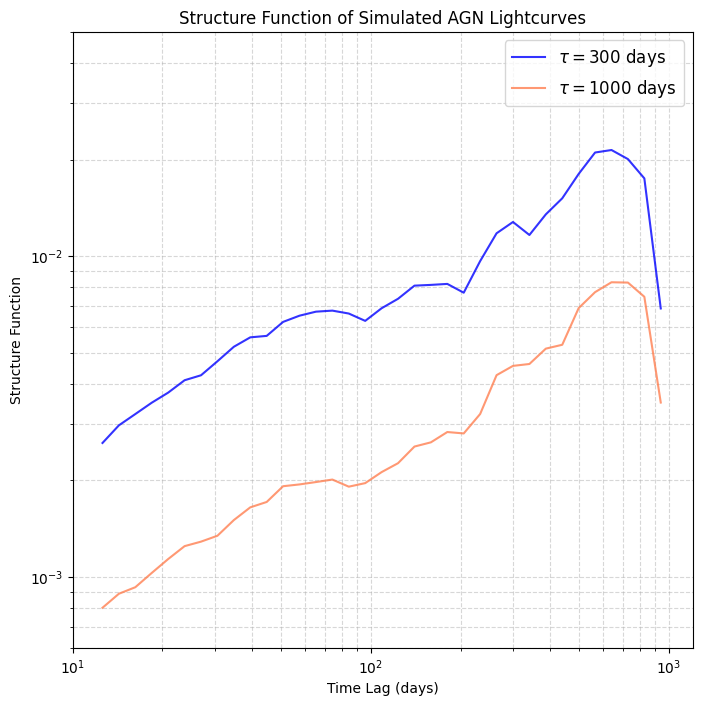

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Structure Function of Simulated AGN Lightcurves")
plt.xlabel("Time Lag (days)")
plt.ylabel("Structure Function")
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Compute SFs for different AGN lightcurves
sf_A_time, sf_A_values = compute_structure_function(time, lightcurve_low_tau)
sf_B_time, sf_B_values = compute_structure_function(time, lightcurve_high_tau)
sf_C_time, sf_C_values = compute_structure_function(time, lightcurve_with_bump)

# Plot the results
plt.loglog(sf_A_time, sf_A_values, linestyle='-', color="blue", alpha=0.8, label=r"$\tau = 300$ days")
plt.loglog(sf_B_time, sf_B_values, linestyle='-', color="coral", alpha=0.8, label=r"$\tau = 1000$ days ")

# Adjust limits to reduce whitespace
plt.xlim(10, 1200)  # Crop time lag range
plt.ylim(6e-4, 5e-2)  # Crop SF values range

plt.legend(loc="best", fontsize=12, frameon=True)
plt.show()

### Structure Function (SF) Definition

The first-order **structure function (SF)** is defined as:

SF(Δt) = √⟨(m(t + Δt) - m(t))²⟩

where:
- **m(t)** is the magnitude (or flux) of the lightcurve at time **t**.
- **Δt** is the time lag.
- The **average (⟨⋅⟩)** is taken over all pairs of observations separated by **Δt**.

#### Binned Estimation
To compute the SF from **observational data**:
1. Compute all pairwise differences:
   - **Δm² = (mᵢ - mⱼ)²**, where **i, j** are indices of observations with **|tᵢ - tⱼ| ≈ Δt**.
2. Group these differences into **logarithmic bins** of **Δt**.
3. Compute the **median** **Δm²** in each bin.
4. Take the **square root** to obtain the final SF values.

#### Interpretation
- **At small \( \Delta t \):** SF is low (small variations).
- **At large \( \Delta t \):** SF saturates at the characteristic variability amplitude.
- **Periodic signals:** Appear as **oscillations** in the SF.

#### In Our Plot
Since our DRW can only walk so far on small timescales, we are not surprised to find **little variation** at **lower time lags**.

Now, let's take a look at more SFs, including the light curve with the added signal:

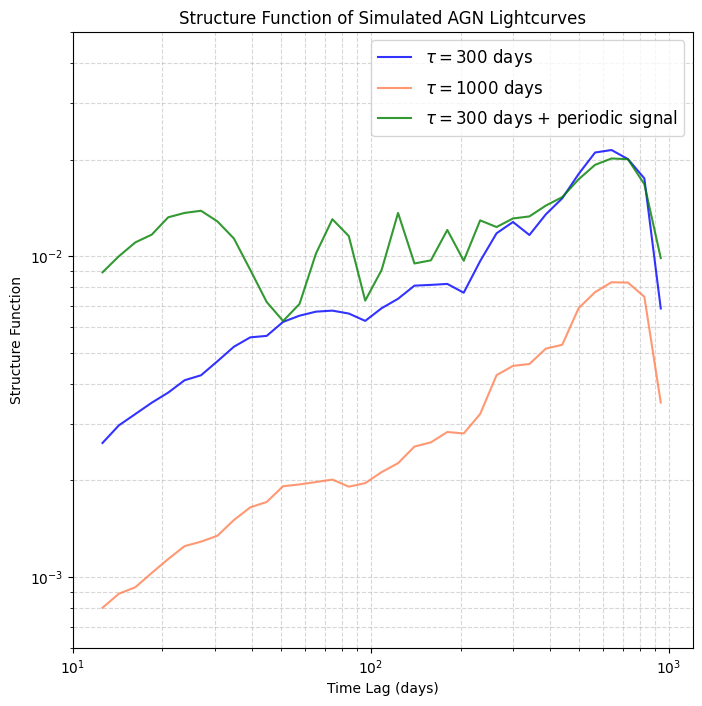

In [12]:
plt.figure(figsize=(8, 8))
plt.title("Structure Function of Simulated AGN Lightcurves")
plt.xlabel("Time Lag (days)")
plt.ylabel("Structure Function")
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Compute SFs for different AGN lightcurves
sf_A_time, sf_A_values = compute_structure_function(time, lightcurve_low_tau)
sf_B_time, sf_B_values = compute_structure_function(time, lightcurve_high_tau)
sf_C_time, sf_C_values = compute_structure_function(time, lightcurve_with_bump)

# Plot the results
plt.loglog(sf_A_time, sf_A_values, linestyle='-', color="blue", alpha=0.8, label=r"$\tau = 300$ days")
plt.loglog(sf_B_time, sf_B_values, linestyle='-', color="coral", alpha=0.8, label=r"$\tau = 1000$ days")
plt.loglog(sf_C_time, sf_C_values, linestyle='-', color="green", alpha=0.8, label=r"$\tau = 300$ days + periodic signal")

# Adjust limits to reduce whitespace
plt.xlim(10, 1200)  # Crop time lag range
plt.ylim(6e-4, 5e-2)  # Crop SF values range

plt.legend(loc="best", fontsize=12, frameon=True)
plt.show()

Again, the only difference in these light curves is an added sinusoudal signal at a frequency ≈ 3e-2 days^-1

TODO expand or maybe not

## Practical Applications of SFs for AGN Variability

**Breaks in SFs correspond to **damping timescales**,**
- which tells us how long it takes for AGN brightness fluctiations to "forget" their past values. 
- This timescale is linked to accretion disk physics and can help us probe the sze of the emitting region in the AGN accretion disk.


**Constraining black hole mass**
- (oh no I hand-wrote this mathematical part...) so if you can measure tau from the SF, you can estimate the black hole mass.

**Identify changing-look AGNs,**
- which turn "on" or "off" and thus show strong deviations from the standard SF shape. 
- Abnormal SF shapes can help us find AGN that are undergoing dramatic accretion state transitions (eg, magnetic instabilities, disc shutdown)

**Large scale surveys (LSST, SDSS, PanSTARRS) to see how AGN variability changes over time**
- Do early universe (high-z) AGN show different variability patterns than nearby AGNs?